##🚀 Introduction


*   This notebook demonstrates the implementation of a **Generative Adversarial Network (GAN)** for generating realistic 32x32 RGB face images using the CelebA dataset.

*   **The GAN architecture** consists of two neural networks — a generator and a discriminator — trained in an adversarial manner.

*   **The generator** learns to synthesize plausible images from random noise, while the discriminator strives to distinguish real images from fakes.

*   Leveraging **TensorFlow and Keras**,
this project covers dataset preparation, model design, training loops with label smoothing, and visualization of results.

*   The goal is to enable high-quality image generation through stable GAN training and systematic progress monitoring.

## 1. Imports and Setup


In [1]:
import os
import time
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mpl_toolkits.axes_grid1 import ImageGrid

from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, Reshape, Activation

## 2. Mount Google Drive and Load Dataset


In [2]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Define paths
data_dir = '/content/drive/MyDrive/data.zip'  # Path to dataset zip file
extract_to_dir = '/content/data'               # Directory to extract dataset

Mounted at /content/drive


In [3]:
# Extract zip file
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# Verify extracted contents
extracted_contents = os.listdir(extract_to_dir)
print(f"Contents of '{extract_to_dir}': {extracted_contents}")

# Path to images inside extracted folder
directory = '/content/data/img_align_celeba'

Contents of '/content/data': ['list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_attr_celeba.csv', 'list_eval_partition.csv', 'list_bbox_celeba.csv']


## 3. Prepare Dataset for Training


In [4]:
# Load images from directory as TensorFlow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=directory,
    color_mode='rgb',
    batch_size=128,
    image_size=(32, 32),
    label_mode=None,
    shuffle=True,
    seed=42
)

Found 202599 files.


In [5]:
# Normalize images to [-1, 1] range and optimize data pipeline
dataset = dataset.map(lambda x: x / 255.00)

## 4. Visualize Sample Images


In [6]:
# Get first batch of images
it = iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:10]  # Select first 10 images

Displaying images from the input dataset...


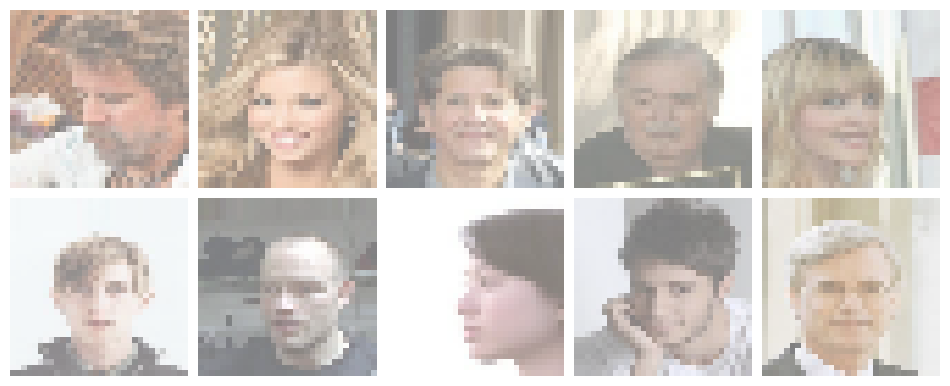

In [7]:
print("Displaying images from the input dataset...")

# Display images in 2x5 grid, rescaled to [0,1] for visualization
fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig=fig, rect=111, nrows_ncols=(2, 5), axes_pad=0.1)

for ax, im in zip(grid, images):
    # Rescale from [-1,1] to [0,1] for display
    im_rescaled = (im + 1.0) / 2.0
    im_rescaled = np.clip(im_rescaled, 0, 1)
    ax.imshow(im_rescaled)
    ax.axis('off')  # Hide axes

plt.show()

## 5. Define the Discriminator Model


In [8]:
def discriminator_model():
    """
    Builds the discriminator model for a GAN.
    This model classifies input images as real or fake.

    Returns:
        Model: A compiled Keras Model representing the discriminator.
    """
    disc_input = Input(shape=(32, 32, 3), name='discriminator_network')

    # Convolution Block 1
    x = Conv2D(64, 3, strides=2, padding='same', kernel_initializer=HeUniform())(disc_input)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Convolution Block 2
    x = Conv2D(128, 3, strides=2, padding='same', kernel_initializer=HeUniform())(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Convolution Block 3
    x = Conv2D(128, 3, strides=2, padding='same', kernel_initializer=HeUniform())(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Convolution Block 4
    x = Conv2D(64, 3, strides=2, padding='same', kernel_initializer=HeUniform())(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Flatten and output
    x = Flatten()(x)
    x = Dense(1)(x)
    output = Activation('sigmoid')(x)

    disc = Model(inputs=disc_input, outputs=output, name='Discriminator')
    return disc

In [9]:
# Instantiate and compile discriminator
disc_model = discriminator_model()
disc_model.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_network           │ (None, 32, 32, 3)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,281 (1.13 MB)

 Trainable params: 297,281 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile discriminator with Adam optimizer and binary cross-entropy loss for stable training.
disc_model.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## 6. Define the Generator Model


In [11]:
def generator_model(z_dim=100):
    """
    Builds the generator model for a GAN.
    Takes a latent vector and generates a fake image.

    Args:
        z_dim (int): Dimension of the latent noise vector.

    Returns:
        Model: A Keras Model representing the generator.
    """
    gen_input = Input(shape=(z_dim,), name='generator_network')

    x = Dense(8 * 8 * 256)(gen_input)
    x = Reshape((8, 8, 256))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Upsampling blocks
    x = Conv2DTranspose(512, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Output layer
    x = Conv2DTranspose(3, 3, strides=1, padding='same')(x)
    fake_images_gen = Activation('tanh')(x)

    model_gen = Model(inputs=gen_input, outputs=fake_images_gen, name='Generator')
    return model_gen


In [12]:
# Instantiate generator
gen_model = generator_model()
gen_model.summary(0)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_network (InputLayer)  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     1,180,160 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,538,371 (17.31 MB)

 Trainable params: 4,535,683 (17.30 MB)

 Non-trainable params: 2,688 (10.50 KB)

## 7. Setup Combined GAN Model

In [13]:
# Adjust discriminator learning rate
disc_model.compile(
    optimizer=Adam(learning_rate=0.0001, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Latent space dimension
z_dim = 100
model_input = Input(shape=(z_dim,), name='model_input')

# Freeze discriminator and set generator trainable for GAN training
disc_model.trainable = False
gen_model.trainable = True

# GAN output: discriminator's classification of generated image
model_output = disc_model(gen_model(model_input))

# Build GAN model
model = Model(model_input, model_output)

In [15]:
# Compile GAN model
model.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ model_input (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Generator (Functional)          │ (None, 32, 32, 3)      │     4,538,371 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Discriminator (Functional)      │ (None, 1)              │       297,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,835,652 (18.45 MB)

 Trainable params: 4,535,683 (17.30 MB)

 Non-trainable params: 299,969 (1.14 MB)

## 8. Training Helper Functions


In [17]:
def train_discriminator(batch, batch_size):
    """
    Train discriminator on a batch of real and fake images.

    Args:
        batch (Tensor): Real images batch.
        batch_size (int): Batch size.

    Returns:
        tuple: Loss on real images, loss on fake images.
    """
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    disc_model.trainable = True

    # Train on real images
    disc_loss_real = disc_model.train_on_batch(batch, valid)

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    gen_image = gen_model.predict(noise, verbose=0)

    # Train on fake images
    disc_loss_fake = disc_model.train_on_batch(gen_image, fake)

    return disc_loss_real, disc_loss_fake

In [18]:
def train_generator(batch_size):
    """
    Train generator via GAN model.

    Args:
        batch_size (int): Batch size.

    Returns:
        tuple: Generator loss and accuracy.
    """
    valid = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dim))

    disc_model.trainable = False

    gen_loss, gen_acc = model.train_on_batch(noise, valid)
    return gen_loss, gen_acc

In [19]:
def generate_and_save_image(path, z_dim=100):
    """
    Generate a fake image, save it to disk, and display it.

    Args:
        path (str): File path to save the image.
        z_dim (int): Latent noise dimension.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)

    noise = np.random.normal(0, 1, (1, z_dim))
    fake_image = gen_model(noise)[0]

    fake_image = tf.clip_by_value((fake_image + 1.0) / 2.0, 0.0, 1.0)

    image = tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
    tf.keras.preprocessing.image.save_img(path, image)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [20]:
def plot_progression(num_epochs, image_dir='generate_face'):
    """
    Plot generated images from each epoch in a row to visualize training progression.

    Args:
        num_epochs (int): Number of epochs.
        image_dir (str): Directory containing saved images.
    """
    fig, axes = plt.subplots(1, num_epochs, figsize=(num_epochs * 2, 2))

    for epoch in range(1, num_epochs + 1):
        image_path = f"{image_dir}/epochs_{epoch}/preview.jpg"
        if os.path.exists(image_path):
            img = mpimg.imread(image_path)
            axes[epoch - 1].imshow(img)
            axes[epoch - 1].axis('off')
            axes[epoch - 1].set_title(f'E{epoch}', fontsize=8)
        else:
            axes[epoch - 1].axis('off')
            axes[epoch - 1].set_title(f'Missing E{epoch}', fontsize=8, color='red')

    plt.tight_layout()
    plt.show()

In [21]:
def plot_generator_accuracy_epoch(g_acc_per_epoch):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(g_acc_per_epoch) + 1)

    # Plot line connecting accuracies across epochs
    plt.plot(epochs, g_acc_per_epoch, label='Generator Accuracy', color='green', marker='o', markersize=8)

    # Annotate each point with its accuracy value for clarity
    for epoch, acc in zip(epochs, g_acc_per_epoch):
        plt.text(epoch, acc + 0.01, f"{acc:.3f}", ha='center', va='bottom', fontsize=9)

    plt.title('Generator Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # show integer epoch numbers on x-axis
    plt.grid(True)
    plt.legend()
    plt.show()

## 9. Training Loop


In [22]:
# Initialize loss trackers
d_loss_real_list = []
d_loss_fake_list = []
g_loss_list = []

g_acc_list = []


🔁 Epoch 01/9
[E01 | B0001] D(real): loss=0.9097, acc=0.3802 | D(fake): loss=0.8125, acc=0.3799 | G: loss=0.5209, acc=0.7734
[E01 | B0002] D(real): loss=0.6433, acc=0.5048 | D(fake): loss=0.6547, acc=0.4312 | G: loss=0.2730, acc=0.8867
[E01 | B0003] D(real): loss=0.5597, acc=0.5001 | D(fake): loss=0.5768, acc=0.4542 | G: loss=0.1837, acc=0.9245
[E01 | B0004] D(real): loss=0.5180, acc=0.4994 | D(fake): loss=0.5337, acc=0.4660 | G: loss=0.1385, acc=0.9434
[E01 | B0005] D(real): loss=0.4922, acc=0.4996 | D(fake): loss=0.5057, acc=0.4732 | G: loss=0.1112, acc=0.9547
[E01 | B0006] D(real): loss=0.4743, acc=0.4998 | D(fake): loss=0.4858, acc=0.4782 | G: loss=0.0930, acc=0.9622
[E01 | B0007] D(real): loss=0.4607, acc=0.5000 | D(fake): loss=0.4705, acc=0.4819 | G: loss=0.0800, acc=0.9676
[E01 | B0008] D(real): loss=0.4495, acc=0.5029 | D(fake): loss=0.4578, acc=0.4939 | G: loss=0.0704, acc=0.9717
[E01 | B0009] D(real): loss=0.4396, acc=0.5227 | D(fake): loss=0.4467, acc=0.5274 | G: loss=0.0629

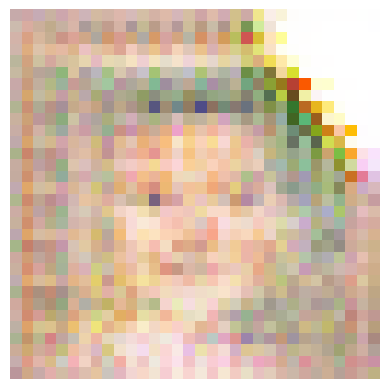

🕒 Epoch 01 completed in 538.58s

🔁 Epoch 02/9
[E02 | B0001] D(real): loss=0.2756, acc=0.8690 | D(fake): loss=0.2755, acc=0.8690 | G: loss=0.3565, acc=0.8934
[E02 | B0002] D(real): loss=0.2754, acc=0.8690 | D(fake): loss=0.2754, acc=0.8691 | G: loss=0.3563, acc=0.8934
[E02 | B0003] D(real): loss=0.2753, acc=0.8691 | D(fake): loss=0.2753, acc=0.8691 | G: loss=0.3560, acc=0.8935
[E02 | B0004] D(real): loss=0.2751, acc=0.8692 | D(fake): loss=0.2751, acc=0.8692 | G: loss=0.3558, acc=0.8936
[E02 | B0005] D(real): loss=0.2750, acc=0.8693 | D(fake): loss=0.2750, acc=0.8693 | G: loss=0.3556, acc=0.8936
[E02 | B0006] D(real): loss=0.2749, acc=0.8693 | D(fake): loss=0.2748, acc=0.8694 | G: loss=0.3554, acc=0.8937
[E02 | B0007] D(real): loss=0.2747, acc=0.8694 | D(fake): loss=0.2747, acc=0.8694 | G: loss=0.3552, acc=0.8938
[E02 | B0008] D(real): loss=0.2746, acc=0.8695 | D(fake): loss=0.2745, acc=0.8695 | G: loss=0.3549, acc=0.8938
[E02 | B0009] D(real): loss=0.2744, acc=0.8696 | D(fake): loss=0.2

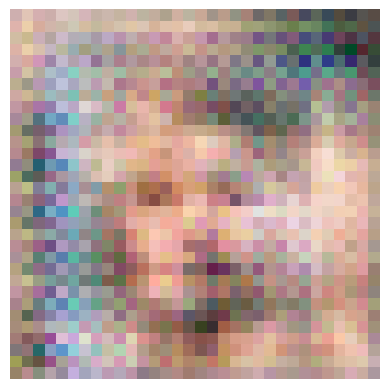

🕒 Epoch 02 completed in 501.97s

🔁 Epoch 03/9
[E03 | B0001] D(real): loss=0.2061, acc=0.9104 | D(fake): loss=0.2061, acc=0.9104 | G: loss=0.2168, acc=0.9322
[E03 | B0002] D(real): loss=0.2061, acc=0.9104 | D(fake): loss=0.2060, acc=0.9104 | G: loss=0.2167, acc=0.9322
[E03 | B0003] D(real): loss=0.2060, acc=0.9104 | D(fake): loss=0.2060, acc=0.9105 | G: loss=0.2166, acc=0.9322
[E03 | B0004] D(real): loss=0.2060, acc=0.9105 | D(fake): loss=0.2059, acc=0.9105 | G: loss=0.2166, acc=0.9322
[E03 | B0005] D(real): loss=0.2059, acc=0.9105 | D(fake): loss=0.2059, acc=0.9105 | G: loss=0.2165, acc=0.9322
[E03 | B0006] D(real): loss=0.2059, acc=0.9105 | D(fake): loss=0.2058, acc=0.9105 | G: loss=0.2164, acc=0.9323
[E03 | B0007] D(real): loss=0.2058, acc=0.9105 | D(fake): loss=0.2058, acc=0.9105 | G: loss=0.2163, acc=0.9323
[E03 | B0008] D(real): loss=0.2058, acc=0.9106 | D(fake): loss=0.2057, acc=0.9106 | G: loss=0.2163, acc=0.9323
[E03 | B0009] D(real): loss=0.2057, acc=0.9106 | D(fake): loss=0.2

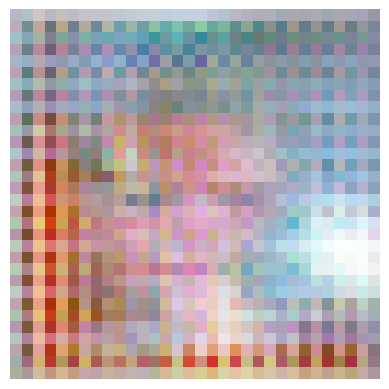

🕒 Epoch 03 completed in 501.26s

🔁 Epoch 04/9
[E04 | B0001] D(real): loss=0.1575, acc=0.9341 | D(fake): loss=0.1575, acc=0.9341 | G: loss=0.1677, acc=0.9485
[E04 | B0002] D(real): loss=0.1575, acc=0.9341 | D(fake): loss=0.1575, acc=0.9341 | G: loss=0.1676, acc=0.9486
[E04 | B0003] D(real): loss=0.1574, acc=0.9341 | D(fake): loss=0.1574, acc=0.9341 | G: loss=0.1676, acc=0.9486
[E04 | B0004] D(real): loss=0.1574, acc=0.9341 | D(fake): loss=0.1574, acc=0.9341 | G: loss=0.1676, acc=0.9486
[E04 | B0005] D(real): loss=0.1574, acc=0.9342 | D(fake): loss=0.1574, acc=0.9342 | G: loss=0.1675, acc=0.9486
[E04 | B0006] D(real): loss=0.1574, acc=0.9342 | D(fake): loss=0.1573, acc=0.9342 | G: loss=0.1675, acc=0.9486
[E04 | B0007] D(real): loss=0.1573, acc=0.9342 | D(fake): loss=0.1573, acc=0.9342 | G: loss=0.1675, acc=0.9486
[E04 | B0008] D(real): loss=0.1573, acc=0.9342 | D(fake): loss=0.1573, acc=0.9342 | G: loss=0.1674, acc=0.9486
[E04 | B0009] D(real): loss=0.1573, acc=0.9342 | D(fake): loss=0.1

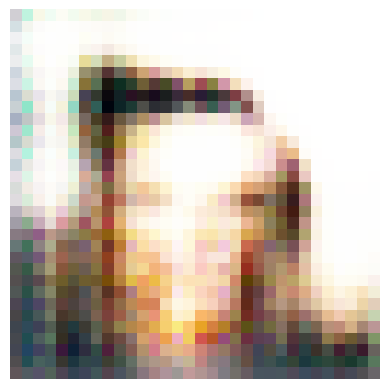

🕒 Epoch 04 completed in 501.97s

🔁 Epoch 05/9
[E05 | B0001] D(real): loss=0.1294, acc=0.9474 | D(fake): loss=0.1294, acc=0.9474 | G: loss=0.1392, acc=0.9583
[E05 | B0002] D(real): loss=0.1294, acc=0.9474 | D(fake): loss=0.1294, acc=0.9474 | G: loss=0.1392, acc=0.9583
[E05 | B0003] D(real): loss=0.1294, acc=0.9474 | D(fake): loss=0.1293, acc=0.9474 | G: loss=0.1392, acc=0.9583
[E05 | B0004] D(real): loss=0.1293, acc=0.9475 | D(fake): loss=0.1293, acc=0.9475 | G: loss=0.1392, acc=0.9583
[E05 | B0005] D(real): loss=0.1293, acc=0.9475 | D(fake): loss=0.1293, acc=0.9475 | G: loss=0.1391, acc=0.9583
[E05 | B0006] D(real): loss=0.1293, acc=0.9475 | D(fake): loss=0.1293, acc=0.9475 | G: loss=0.1391, acc=0.9583
[E05 | B0007] D(real): loss=0.1293, acc=0.9475 | D(fake): loss=0.1293, acc=0.9475 | G: loss=0.1391, acc=0.9584
[E05 | B0008] D(real): loss=0.1293, acc=0.9475 | D(fake): loss=0.1293, acc=0.9475 | G: loss=0.1391, acc=0.9584
[E05 | B0009] D(real): loss=0.1293, acc=0.9475 | D(fake): loss=0.1

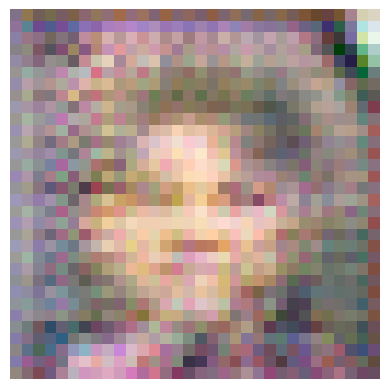

🕒 Epoch 05 completed in 500.83s

🔁 Epoch 06/9
[E06 | B0001] D(real): loss=0.1107, acc=0.9558 | D(fake): loss=0.1107, acc=0.9558 | G: loss=0.1212, acc=0.9643
[E06 | B0002] D(real): loss=0.1107, acc=0.9558 | D(fake): loss=0.1107, acc=0.9558 | G: loss=0.1212, acc=0.9643
[E06 | B0003] D(real): loss=0.1107, acc=0.9558 | D(fake): loss=0.1107, acc=0.9558 | G: loss=0.1212, acc=0.9643
[E06 | B0004] D(real): loss=0.1107, acc=0.9558 | D(fake): loss=0.1107, acc=0.9558 | G: loss=0.1211, acc=0.9643
[E06 | B0005] D(real): loss=0.1107, acc=0.9558 | D(fake): loss=0.1107, acc=0.9558 | G: loss=0.1211, acc=0.9643
[E06 | B0006] D(real): loss=0.1107, acc=0.9558 | D(fake): loss=0.1107, acc=0.9558 | G: loss=0.1211, acc=0.9643
[E06 | B0007] D(real): loss=0.1107, acc=0.9558 | D(fake): loss=0.1107, acc=0.9558 | G: loss=0.1211, acc=0.9643
[E06 | B0008] D(real): loss=0.1107, acc=0.9559 | D(fake): loss=0.1107, acc=0.9559 | G: loss=0.1211, acc=0.9643
[E06 | B0009] D(real): loss=0.1106, acc=0.9559 | D(fake): loss=0.1

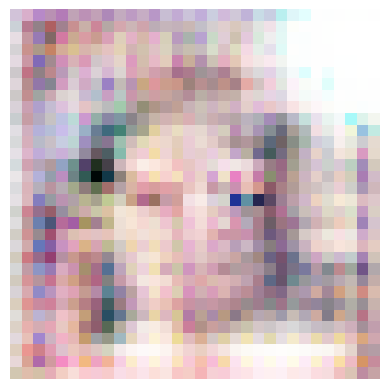

🕒 Epoch 06 completed in 502.45s

🔁 Epoch 07/9
[E07 | B0001] D(real): loss=0.0970, acc=0.9618 | D(fake): loss=0.0970, acc=0.9618 | G: loss=0.1139, acc=0.9679
[E07 | B0002] D(real): loss=0.0970, acc=0.9618 | D(fake): loss=0.0970, acc=0.9618 | G: loss=0.1139, acc=0.9679
[E07 | B0003] D(real): loss=0.0970, acc=0.9618 | D(fake): loss=0.0970, acc=0.9618 | G: loss=0.1138, acc=0.9679
[E07 | B0004] D(real): loss=0.0970, acc=0.9618 | D(fake): loss=0.0970, acc=0.9618 | G: loss=0.1138, acc=0.9679
[E07 | B0005] D(real): loss=0.0970, acc=0.9619 | D(fake): loss=0.0970, acc=0.9619 | G: loss=0.1138, acc=0.9679
[E07 | B0006] D(real): loss=0.0970, acc=0.9619 | D(fake): loss=0.0970, acc=0.9619 | G: loss=0.1138, acc=0.9679
[E07 | B0007] D(real): loss=0.0970, acc=0.9619 | D(fake): loss=0.0970, acc=0.9619 | G: loss=0.1138, acc=0.9679
[E07 | B0008] D(real): loss=0.0970, acc=0.9619 | D(fake): loss=0.0970, acc=0.9619 | G: loss=0.1138, acc=0.9679
[E07 | B0009] D(real): loss=0.0970, acc=0.9619 | D(fake): loss=0.0

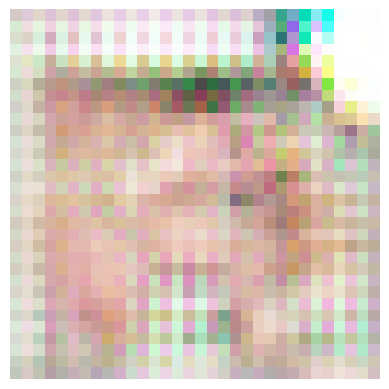

🕒 Epoch 07 completed in 561.98s

🔁 Epoch 08/9
[E08 | B0001] D(real): loss=0.0874, acc=0.9660 | D(fake): loss=0.0874, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0002] D(real): loss=0.0874, acc=0.9660 | D(fake): loss=0.0874, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0003] D(real): loss=0.0874, acc=0.9660 | D(fake): loss=0.0874, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0004] D(real): loss=0.0874, acc=0.9660 | D(fake): loss=0.0874, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0005] D(real): loss=0.0874, acc=0.9660 | D(fake): loss=0.0874, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0006] D(real): loss=0.0874, acc=0.9660 | D(fake): loss=0.0874, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0007] D(real): loss=0.0873, acc=0.9660 | D(fake): loss=0.0873, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0008] D(real): loss=0.0873, acc=0.9660 | D(fake): loss=0.0873, acc=0.9660 | G: loss=0.1090, acc=0.9703
[E08 | B0009] D(real): loss=0.0873, acc=0.9660 | D(fake): loss=0.0

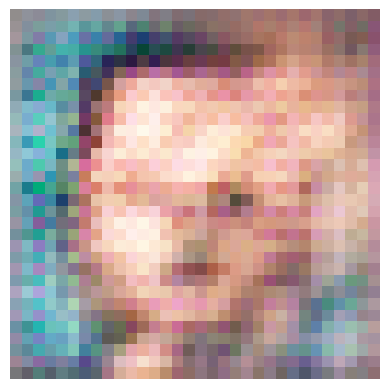

🕒 Epoch 08 completed in 505.85s

🔁 Epoch 09/9
[E09 | B0001] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1030, acc=0.9730
[E09 | B0002] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1030, acc=0.9730
[E09 | B0003] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1029, acc=0.9730
[E09 | B0004] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1029, acc=0.9730
[E09 | B0005] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1029, acc=0.9730
[E09 | B0006] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1029, acc=0.9730
[E09 | B0007] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1029, acc=0.9730
[E09 | B0008] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0792, acc=0.9696 | G: loss=0.1029, acc=0.9730
[E09 | B0009] D(real): loss=0.0792, acc=0.9696 | D(fake): loss=0.0

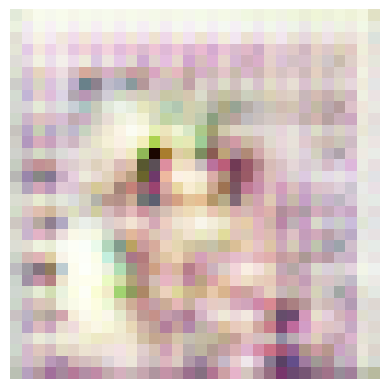

🕒 Epoch 09 completed in 561.98s


In [23]:
g_acc_per_epoch = []  # to store one accuracy value per epoch

for epoch in range(1, 10):
    print(f"\n🔁 Epoch {epoch:02d}/9")
    start_time = time.time()

    last_batch = None
    g_acc_epoch = []  # collect all generator accuracies in this epoch

    for batch_idx, batch in enumerate(dataset, start=1):
        batch_size = batch.shape[0]
        last_batch = batch

        # Train discriminator twice
        d_loss_real_1, d_loss_fake_1 = train_discriminator(batch, batch_size)
        d_loss_real_2, d_loss_fake_2 = train_discriminator(batch, batch_size)

        # Train generator once (get loss and accuracy)
        g_loss, g_acc = train_generator(batch_size)

        # Store averaged losses and batch accuracies
        d_loss_real_list.append((d_loss_real_1[0] + d_loss_real_2[0]) / 2)
        d_loss_fake_list.append((d_loss_fake_1[0] + d_loss_fake_2[0]) / 2)
        g_loss_list.append(g_loss)
        g_acc_list.append(g_acc)

        # Append batch generator accuracy for epoch average
        g_acc_epoch.append(g_acc)

        # Log training progress
        print(
            f"[E{epoch:02d} | B{batch_idx:04d}] "
            f"D(real): loss={(d_loss_real_1[0] + d_loss_real_2[0])/2:.4f}, acc={(d_loss_real_1[1] + d_loss_real_2[1])/2:.4f} | "
            f"D(fake): loss={(d_loss_fake_1[0] + d_loss_fake_2[0])/2:.4f}, acc={(d_loss_fake_1[1] + d_loss_fake_2[1])/2:.4f} | "
            f"G: loss={g_loss:.4f}, acc={g_acc:.4f}"
        )

    # Compute average generator accuracy for the epoch
    avg_g_acc = sum(g_acc_epoch) / len(g_acc_epoch)
    g_acc_per_epoch.append(avg_g_acc)

    # Save and display a preview image at the end of each epoch
    preview_dir = f'generate_face/epochs_{epoch}'
    os.makedirs(preview_dir, exist_ok=True)
    image_path = f'{preview_dir}/preview.jpg'
    print(f"\n📸 Previewing generated image for Epoch {epoch:02d} → {image_path}")
    generate_and_save_image(path=image_path)

    elapsed = time.time() - start_time
    print(f"🕒 Epoch {epoch:02d} completed in {elapsed:.2f}s")

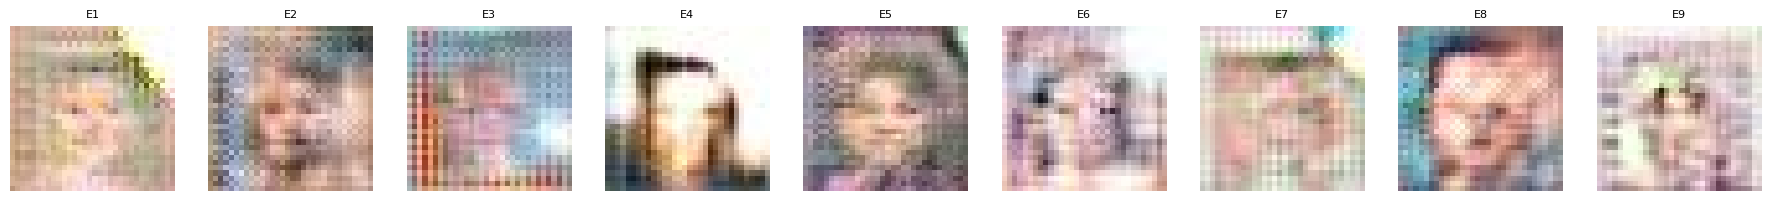

In [24]:
# Plot progression of generated images across epochs
plot_progression(num_epochs=9)

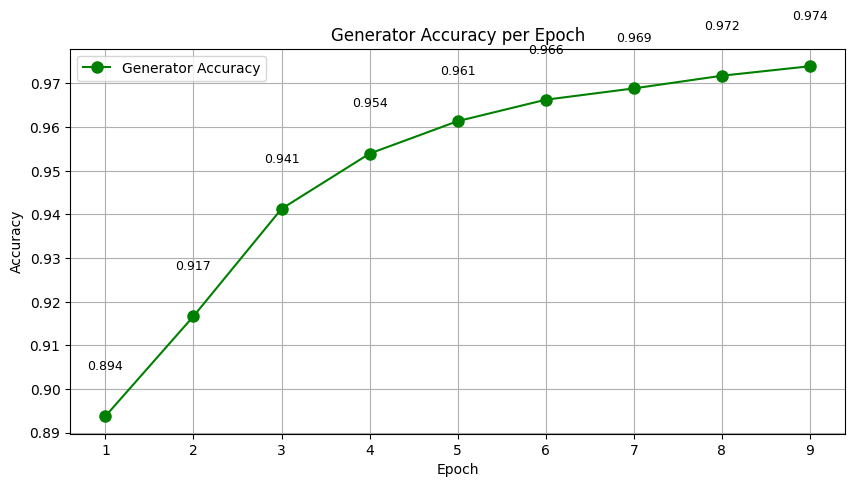

In [25]:
# Plot generator accuracy
plot_generator_accuracy_epoch(g_acc_per_epoch)


The generator accuracy has shown a consistent upward trend over the current training epochs.

With additional computational resources, running the model for more epochs is expected to further improve the generator's accuracy, potentially leading to even higher-quality results.

## 10. Save Final Model Weights

In [26]:
# Save final trained weights of generator and discriminator for future inference or fine-tuning.
gen_model.save_weights('/content/generator_final.weights.h5')
disc_model.save_weights('/content/discriminator_final.weights.h5')

print("✅ Final generator and discriminator weights saved.")

✅ Final generator and discriminator weights saved.


✅ Conclusion


*   This project successfully constructs and trains a GAN model capable of generating visually convincing face images by jointly optimizing convolutional generator and discriminator networks.

*   Through iterative adversarial training and fine-tuning of hyperparameters, the generator improves its ability to create realistic outputs.

*   The notebook includes robust data loading, model compilation, training loops with detailed logging, and visualization techniques to track generation progress. Final trained weights are saved for future reuse or fine-tuning.

*   This implementation provides a solid foundation for advancing GAN research or adapting to other image generation tasks.